# REVIEWING VALUES IN `LANDUSE.TBL`

`LANDUSE.TBL` is used by the land surface model to specify some variables depending on the land surface type. According to the Dudhia WRF Overview presentation, the following are used:

> VEGPARM.TBL used by Noah and RUC for vegetaion category properies

> SOILPARM.TBL used by Noah and RUC for soil properies

> LANDUSE.TBL used by 5-layer model

## We are using the following in the idealized model

- the 5-layer model (`LANDUSE.TBL`)
- USGS section (specified in `namelist.input`)
- The entire time we have land use category number 24 - snow and ice

## Currently for snow and ice:

| Season | Albedo ($\%$) | Suface Moisture Availability ($*100\%$) | Surface Emissivity ($\%$) | Surface Roughness | Thermal Inertia Constant | Snow Cover Effect | Surface Heat Capacity ($J/(m^{3}K)$) | Label       |
| ------ | ------ | ---- | ---- | ---- | ------ | -----| ------ | ----------- |
| Summer | 55.    | .95  | .95  | 0.1  | 5.     | 0.   | 9.0e25 | Snow or Ice |
| Winter | 70.    | .95  | .95  | 0.1  | 5.     | 0.   | 9.0e25 | Snow or Ice |

### Preliminary observations

1. **Albedo** is far too low - ***BUT we have defined this in the namelist*** so this value is not used.
2. **Surface moisture availability** and **emissivity** could both probably be increased.
3. **Surface roughness** could probably be decreased.
4. **Snow cover effects** seem to be constant regardless of surface
5. The **thermal inertial constant** could probably be improved, but I'm not sure what this is.
6. **Surface heat capacity** could be improved.

## How do the measurements measure up?

| Season | Albedo ($\%$) | Surface Moisture Availability ($*100\%$) | Surface Emissivity ($\%$) | Surface Roughness | Thermal Inertia Constant | Snow Cover Effect | Surface Heat Capacity ($J/(m^{3}K)$) | Surface     |
| ------ | ---------- | ---------------------------------- | ---------------------- | ----------------- | ------------------------ | -----| ----------------------------------- | ----------- |
| Summer | 55.        | .95                                | .95                    | 0.1               | 5.                       | 0.   | 9.0e25                              | Snow or Ice |
| Winter | 70.        | .95                                | .95                    | 0.1               | 5.                       | 0.   | 9.0e25                              | Snow or Ice |
| Measurements | 80. \* | ~.95                             | ~.95                   | 0.001             | ?.                       | 0. \** | 8.1e12                          | Sea Ice     |

\* This is defined in the namelist and already taken care of.

\** No snow cover effects because we are over snow/ice already

~ indicates an estimation

### What variables do we need? Where can we get them? 
#### Have
1. Albedo
    - This is already incorporated into the model

#### Calculate
1. Surface roughness length
    - This is calculated below and is much lower than that in the table
    - This could be a good value to adjust
2. Surface heat capacity
    - This is calculated below and is much higher than that in the table
    - I'd like to discuss this variable with Von
3. Thermal inertia constant
    - I am struggling with calculating this, I need to do more reading to understand it
    
#### Can improve estimations
1. Surface moisture availability
    - This is higher only in the values above water
    - The difference is small so it probably would not be a large difference
2. Emissivity
    - Also a small difference so likely not a big change
    
---
## Calculations

### Calculating: Surface Roughness Length

$$ z_{0} = \frac{(z_{2}-z_{1})}{[exp(\frac{kU_{2}}{u*}) - exp(\frac{kU_{1}}{u*})]} $$

- $z_{0}$ is the roughness length
- $z_{1}$ height of $U_{1}$ ($2 m$)
- $z_{2}$ height of $U_{2}$ ($4 m$)
- $k$ is the Von Karmon constant ($0.4$)
- $u*$ is friction velocity (measured, in flux dataset)
- $U_{1}$ wind speed at $z_{1}$ (measued, in meteorology dataset)
- $U_{2}$ wind speed at $z_{2}$ (measued, in meteorology dataset)

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr 
import numpy as np

import json
import time
import datetime

plt.style.use('default')


In [2]:
# Wind speed at 2 m
u1 = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_metData_v2.nc', 
                     decode_times = False)['wind_speed_2m'].mean().values

# Wind speed at 10 m
u2 = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_metData_v2.nc', 
                     decode_times = False)['wind_speed_10m'].mean().values

# Friction velocity
ustar = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_sebData_v1.nc', 
                        decode_times = False)['friction_velocity'].mean().values

# Heights 
z1 = 2 # m
z2 = 10 # m

# Von Karmon Constant
k  = 0.4 

# Calculation
term1 = (z2 - z1)
term2 = np.exp((k * u2) / ustar)
term3 = np.exp((k * u1) / ustar)
z = term1 / (term2 - term3)

print('Surface Roughness Length (m):')
z

Surface Roughness Length (m):


0.0012378941216551337

---
### Calculating: Surface Heat Capacity 

https://ncar.github.io/CAM/doc/build/html/cam5_scientific_guide/sea_ice.html

$$ c(T,S) = c_{0} + \frac{L_{i}\mu S}{T^{2}} $$

- $c(T,S)$ is the heat capacity, J / kg K
- $c_{0}$ is the heat capacity of fresh ice 2054 J kg^{-1} K^{-1}, J / kg K
- $L_{i}$ is the latent heat of fusion 3.340 x 10^5 J / kg, J / kg
- $S$ is the salinity (we have salinity from the ice measurements), g/g
- $T$ is temperature (we have ice surface temperature from the ice measurements), K
- $\mu = T_{f}=-\mu S =  0.054 degC ppt^{-1}$ is the ocean freezing temperature constant

In [3]:
# Importing variables from the Sea Ice Physics dataset
# Sea ice salinity and surface temperature to be used in the surface heat capacity calculations
# Density to be used in this calculation for the thermal inertia constant

with open('/Users/smurphy/all_datasets/nice_published_datasets/n-ice2015-ice-core-physics.json') as f:
    data = json.load(f)
keys, vals = data.items()

density_df = pd.DataFrame()
for i in np.arange(0,len(vals[1]),1):
    if 'density' in vals[1][i].keys():
        mean_level = (np.array(vals[1][i]['sample_top_cm'], dtype=np.float)[~np.isnan(np.array(vals[1][i]['density'], dtype=np.float))] - np.array(vals[1][i]['sample_bottom_cm'], dtype=np.float)[~np.isnan(np.array(vals[1][i]['density'], dtype=np.float))])/2
        den_vals = np.array(vals[1][i]['density'], dtype = np.float)[~np.isnan(np.array(vals[1][i]['density'], dtype = np.float))]
        density_temp_df = pd.DataFrame(data = den_vals.reshape(1, len(den_vals)), 
                                       columns = mean_level,
                                       index = [datetime.datetime.strptime(vals[1][i]['properties']['time'],"%Y-%m-%dT%H:%M:%SZ")])
        density_df = pd.concat([density_df, density_temp_df], axis=1)
        
salinity_df = pd.DataFrame()
for i in np.arange(0,len(vals[1]),1):
    if 'sea_ice_salinity' in vals[1][i].keys():
        den_vals = np.mean(np.array(vals[1][i]['sea_ice_salinity'], dtype = np.float)[~np.isnan(np.array(vals[1][i]['sea_ice_salinity'], dtype = np.float))])
        salinity_temp_df = pd.DataFrame(data = [den_vals], 
                                       index = [datetime.datetime.strptime(vals[1][i]['properties']['time'],"%Y-%m-%dT%H:%M:%SZ")])
        salinity_df = pd.concat([salinity_df, salinity_temp_df], axis=1)
        
surft_df = pd.DataFrame()
for i in np.arange(0,len(vals[1]),1):
    if 'surface_temperature' in vals[1][i]['properties'].keys():
        den_vals = np.array(vals[1][i]['properties']['surface_temperature'], dtype = np.float)[~np.isnan(np.array(vals[1][i]['properties']['surface_temperature'], dtype = np.float))]
        surftemp_temp_df = pd.DataFrame(data = [den_vals], 
                                       index = [datetime.datetime.strptime(vals[1][i]['properties']['time'],"%Y-%m-%dT%H:%M:%SZ")])
        surft_df = pd.concat([surft_df, surftemp_temp_df], axis=1)
        
                
        

#### What value of temperature should I use? 

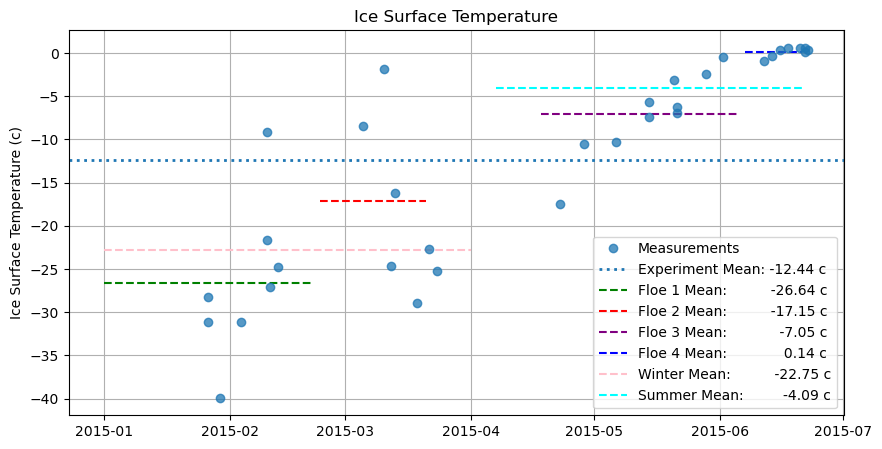

In [4]:
f1 = surft_df['2015-01-01':'2015-02-21']
f2 = surft_df['2015-02-23':'2015-03-21']
f3 = surft_df['2015-04-18':'2015-06-05']
f4 = surft_df['2015-06-07':'2015-06-21']

wint = surft_df['2015-01-01':'2015-04-01']
summ = surft_df['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(surft_df.mean(axis = 1), 'o', alpha = 0.75)

plt.axhline(surft_df.mean(axis = 1).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(axis = 1).mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(axis = 1).mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(axis = 1).mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(axis = 1).mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.ylabel('Ice Surface Temperature (c)')
plt.title('Ice Surface Temperature')
plt.grid()
plt.legend(['Measurements', 'Experiment Mean: ' + str(np.round(surft_df.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 1 Mean:          ' + str(np.round(f1.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 2 Mean:          ' + str(np.round(f2.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 3 Mean:            ' + str(np.round(f3.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 4 Mean:             ' + str(np.round(f4.mean(axis = 1).mean(),2)) + ' c', 
            'Winter Mean:          ' + str(np.round(wint.mean(axis = 1).mean(),2)) + ' c', 
            'Summer Mean:         ' + str(np.round(summ.mean(axis = 1).mean(),2)) + ' c'])

In [5]:
print('Ice surface temperature')
np.round(surft_df.mean(axis = 1).mean(),2)

Ice surface temperature


-12.44

In [6]:
print('Winter surface temperature')
np.round(surft_df['2015-01-01':'2015-04-01'].mean(axis = 1).mean(),2)

Winter surface temperature


-22.75

In [7]:
print('Summer surface temperature')
np.round(surft_df['2015-04-07':'2015-06-21'].mean(axis = 1).mean(),2)

Summer surface temperature


-4.09

#### What value of salinity should I use?

/Users/smurphy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


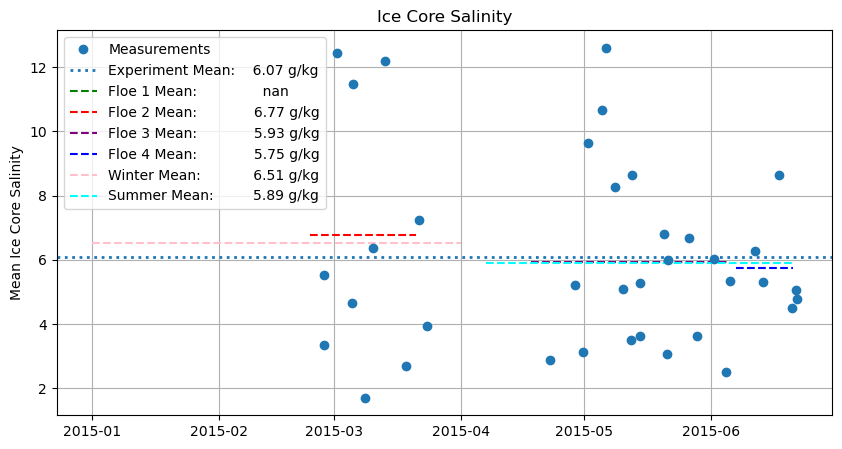

In [8]:

f1 = salinity_df['2015-01-01':'2015-02-21']
f2 = salinity_df['2015-02-23':'2015-03-21']
f3 = salinity_df['2015-04-18':'2015-06-05']
f4 = salinity_df['2015-06-07':'2015-06-21']

wint = salinity_df['2015-01-01':'2015-04-01']
summ = salinity_df['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(salinity_df.mean(axis = 1), 'o')
plt.axhline(salinity_df.mean(axis = 1).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(axis = 1).mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(axis = 1).mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(axis = 1).mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(axis = 1).mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.ylabel('Mean Ice Core Salinity')
plt.title('Ice Core Salinity')
plt.grid()

plt.legend(['Measurements', 'Experiment Mean:    ' + str(np.round(salinity_df.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Floe 1 Mean:               ' + str(np.round(f1.mean(axis = 1).mean(),2)), 
            'Floe 2 Mean:             ' + str(np.round(f2.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Floe 3 Mean:             ' + str(np.round(f3.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Floe 4 Mean:             ' + str(np.round(f4.mean(axis = 1).mean(),2)) + ' g/kg',
            'Winter Mean:            ' + str(np.round(wint.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Summer Mean:         ' + str(np.round(summ.mean(axis = 1).mean(),2)) + ' g/kg'], loc = 'upper left')

In [9]:
print('Mean Ice Core Salinity:')
np.round(salinity_df.mean(axis = 1).mean(),2)

Mean Ice Core Salinity:


6.07

In [10]:
# Ocean freezing temperature constant
mu = 0.054 # c / ppt                 ** this needs to be in K 
mu = mu + 273.15 * (10**12) # K 

# Heat capacity of fresh ice
c0 = 2054 # J / kg K 

# Salinity
s = np.round(salinity_df.mean(axis = 1).mean(),2) # g / kg    ** I think this needs to be in g/g or kg/kg
s = s / 1000 # g / g 

# Ice surface temperature
t = np.round(surft_df.mean(axis = 1).mean(),2) # c                  ** This needs to be in K 
t = t + 273.15 # K

# Ice surface temperature - Summer
t_s = np.round(surft_df['2015-04-07':'2015-06-21'].mean(axis = 1).mean(),2) # c                  ** This needs to be in K 
t_s = t_s + 273.15 # K

# Ice surface temperature - Winter
t_w = np.round(surft_df['2015-01-01':'2015-04-01'].mean(axis = 1).mean(),2) # c                  ** This needs to be in K 
t_w = t_w + 273.15 # K

# Latent heat of fusion
li = 3.340 * 10 ** 5 # J / kg 

# Calculating
c = c0 + ((li * mu * s) / (t**2)) 
c_w = c0 + ((li * mu * s) / (t_w**2)) 
c_s = c0 + ((li * mu * s) / (t_s**2)) 

print('Surface Heat Capacity (J/kg k):')
c

Surface Heat Capacity (J/kg k):


8147436486186.056

In [11]:
print('Winter Surface Heat Capacity (J/kg k):')
c_w # 8.8 * 10^12

Winter Surface Heat Capacity (J/kg k):


8832175980552.303

In [12]:
print('Summer Surface Heat Capacity (J/kg k):')
c_s #7.6 * 10 ^12

Summer Surface Heat Capacity (J/kg k):


7649588740973.975

---
### Calculating: Thermal Interia Constant
***This is for soil, but it appears applicable for this, too***

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JE004618


$$ I = \sqrt{\lambda \rho c} $$

- $I$ is the thermal inertia constant
- $\lambda$ is thermal conductivity (W m-1 k-1)
- $\rho$ is density (kg m-3)
- $c$ is specific heat capacity (J kg-2 k-1)

> Results indicate that increasing the mean salinity induces a higher thermal inertia reducing summer melt and finally increasing ice thickness (https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.909.889&rep=rep1&type=pdf)

#### What value of density should I use?

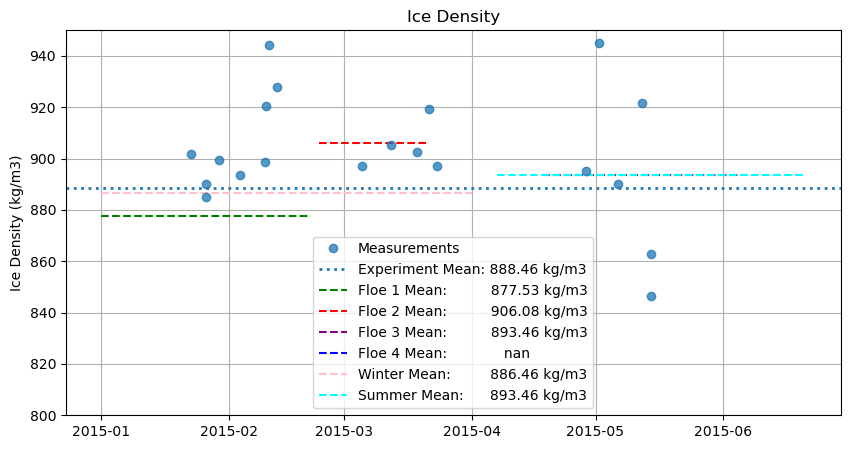

In [13]:
f1 = density_df['2015-01-01':'2015-02-21']
f2 = density_df['2015-02-23':'2015-03-21']
f3 = density_df['2015-04-18':'2015-06-05']
f4 = density_df['2015-06-07':'2015-06-21']

wint = density_df['2015-01-01':'2015-04-01']
summ = density_df['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(density_df.mean(axis = 1), 'o', alpha = 0.75)

plt.axhline(density_df.mean(axis = 1).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(axis = 1).mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(axis = 1).mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(axis = 1).mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(axis = 1).mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.ylabel('Ice Density (kg/m3)')
plt.title('Ice Density')
plt.ylim(800, 950)
plt.grid()
plt.legend(['Measurements', 'Experiment Mean: ' + str(np.round(density_df.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 1 Mean:          ' + str(np.round(f1.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 2 Mean:          ' + str(np.round(f2.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 3 Mean:          ' + str(np.round(f3.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 4 Mean:             ' + str(np.round(f4.mean(axis = 1).mean(),2)),
            'Winter Mean:         ' + str(np.round(wint.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Summer Mean:      ' + str(np.round(summ.mean(axis = 1).mean(),2)) + ' kg/m3'], loc = 'lower center')

In [14]:
# Thermal Conductivity
## Thermal conductivity from SHEBA https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2000JC000409
### This suggests that we should use 0.3 from measurements at SHEBA
### I can't find any further measurements of this from N-ICE so I'm going to use this constant derived from SHEBA.
tc = 0.3 # W / m K

# Density
den = np.round(density_df.mean(axis = 1).mean(),2) # kg / m3

# Specific heat capacity
## I think this is the same as the surface heat capacity for this application
shc = c # J / kg2 k

print('Thermal Inertia Constant is:')
np.sqrt(tc * den * shc)

Thermal Inertia Constant is:


46600444.484522454

# Summary

- The **surface roughness** and **surface heat capacity** can likely be improved in `LANDUSE.TBL`
    - Surface roughness can be decreased to 0.001 or 0.01. The former is more accurate, but I'm not sure how many orders of magnitude WRF can obtain from `LANDUSE.TBL`.
    - Specific heat capacity may be too high, but I'm concerned my calculations could be wrong.
    
- **Thermal inertia constant** could also likely be improved, but I know my calculations are incorrect.

## How does this stack up to Polar WRF and values used by other schemes for snow and ice?

### Other sections from `LANDUSE.TBL`

| Section | Season | Albedo (%) | Suface Moisture Availability (*100%) | Surface Emissivity (%) | Surface Roughness | Thermal Inertia Constant | Snow Cover Effect | Surface Heat Capacity (j/m3 K) | Label       |
| ------- | ------ | ------ | ---- | ---- | ---- | ------ | -----| ------ | ------------- |
| OLD     | Summer | 55.    | .95  | .95  | 5.   | 5.     | 0.   | 9.0e25 | Permanent Ice |
| OLD     | Winter | 70.    | .95  | .95  | 5.   | 5.     | 0.   | 9.0e25 | Permanent Ice |
| USGS    | Summer | 55.    | .95  | .95  | 0.1  | 5.     | 0.   | 9.0e25 | Snow or Ice   |
| USGS    | Winter | 70.    | .95  | .95  | 0.1  | 5.     | 0.   | 9.0e25 | Snow or Ice   |
| MODIFIED_IGBP_MODIS_NOAH | Summer | 55. | .95 | .95 | 0.1 | 5. | 0 | 9.0e25 | Snow or Ice |
| MODIFIED_IGBP_MODIS_NOAH | Winter | 70. | .95 | .95 | 0.1 | 5. | 0 | 9.0e25 | Snow or Ice |
| SiB     | Summer | 55.    | .95  | .95  | 5.   | 5.     | 0.   | 9.0e25 | Ice Cap and Glacier |
| SiB     | Winter | 70.    | .95  | .95  | 5.   | 5.     | 0.   | 9.0e25 | Ice Cap and Glacier |
| LW12    | All    | 70.    | .95  | .95  | 5.   | 5.     | 0.   | 9.0e25 | Snow and Ice |
| MODIS   | Summer | 55.    | .95  | .95  | 1.   | 5.     | 0.   | 9.0e25 | Snow and Ice |
| MODIS   | Winter | 55.    | .95  | .98  | 1.0  | 5.     | 0.   | 9.0e25 | Snow and Ice |
| SSIB    | Summer | 55.    | .95  | .95  | 0.1  | 5.     | 0.   | 9.0e25 | Snow or Ice |    
| SSIB    | Winter | 70.    | .95  | .95  | 0.1  | 5.     | 0.   | 9.0e25 | Snow or Ice |   
| NLCD40  | Summer | 60.    | .95  | .95  | 1.2  | 5.     | 0.   | 9.0e25 | Permanent Snow and Ice |     
| NLCD40  | Winter | 60.    | .95  | .95  | 1.2  | 5.     | 0.   | 9.0e25 | Permanent Snow and Ice |    

- Albedos overall are lower than those observed at N-ICE
- Soil moisture availability is 0.95 in all the simulations
- Emissivity is higher in some situations, N-ICE simulations could potentially benefit from using the 0.98 instead of 0.95
- Surface roughness is the lowest in the section used, but it is still higher than that calculated fro N-ICE
- Thermal interia constant, snow cover effects, and the surface heat capacity are the same in all simualtions
    - If my calculations of the surface heat capacity are correct, simulations could likely be improved by lowering this value.

### Other values in `VEGPARM.TBL`
** Not used in the idealized simulations **

| Section | Vegetation Fraction | Rooting Depth | Stomatal Resistance | Radiation Stress | Vapor Pressure Deficit Function Parameter | Soil Water Equivalent Snow Depth | Maximum Albedo Over Deep Snow | Minimum LAI | Maximum LAI | Minimum Emissivity | Maximum Emissivity | Minimum Albedo | Maximum Albedo | Minimum Roughness Length | Maximum Roughness Length | Category |
| ---- | - | - | --- | --- | --- | ---- | -- | ---- | ---- | ---- | ---- | ---- | ---- | ----- | ----- | ----------- |
| USGS | 0 | 1 | 999 | 999 | 999 | 0.02 | 82 | 0.01 | 0.01 | 0.95 | 0.95 | 0.55 | 0.70 | 0.001 | 0.001 | Snow or Ice |
| MODIFIED_IGBP_MODIS_NOAH | 0 | 1 | 999 | 999 | 999 | 0.02 | 82 | 0.01 | 0.01 | 0.95 | 0.95 | .55 | .7 | 0.001 | 0.001 | Snow and Ice |
| NLDC | 0 | 1 | 999 | 999 | 999 | 0.02 | 82 | 0.01 | 0.01 | 0.95 | 0.95 | 0.55 | 0.70 | 0.001 | 0.001 | Permanent Snow |
| NLDC | 0 | 1 | 999 | 999 | 999 | 0.02 | 82 | 0.01 | 0.01 | 0.95 | 0.95 | 0.55 | 0.70 | 0.001 | 0.001 | Perennial Ice/Snow |

| Section | Albedo | Roughness Length | LEMI\* | PC\* | Vegetation Factor | IFOR\* | Stomatal Resistance | Radiation Stress | Vapor Pressure Deficit Function Parameter | Soil Water Equivalent Snow Depth | LAI | Maximum Albedo | Category|
| -------- | ---- | ------ | ---- | ---- | ---- | - | ---- | ---- | ---- | ---- | ---- | -- | ------------- |
| USGS-RUC | 0.55 | 0.0024 | 0.98 | 0.00 | 0.00 | 9 | 999. | 999. | 999. | 0.02 | 0.01 | 75 | Snow or Ice   | 
| MODIS-RUC | 0.55 | 0.011 | 0.98 | 0.00 | 0.00 | 9 | 999. | 999. | 999. | 0.02 | 0.01 | 82 | Snow and Ice  |

\* I Don't know what some of these are 
- The maximum albedo is higher here than in `LANDUSE.TBL`, closer to that seen at N-ICE and the value used in the simulations.
- Roughness lengths are closer to what I've calculated for N-ICE
- Emissivities are similar to those seen in `LANDUSE.TBL`

### Other values in `SOILPARM.TBL`
** Not used in the idealized simulation, for land-ice **

| Section | B Parameter | Dry Soil Moisture Threshold | Soil Thermal Diffusivity/Conducticity Coefficient | Saturation Soil Moisture Content | Reference Soil Moisture | Saturday Soil Matric Potential | Saturation Soil Conductivity | Saturation Soil Diffusivity | Wilting Point Soil Moisture | Soil Quartz Content |
| -------- | ---- | ----- | ------ | ----- | ----- | ----- | ------- | -------- | -------- | ----- |       
| STAS     | 4.26 | 0.028 | -1.044 | 0.421 | 0.283 | 0.036 | 1.41E-5 | 0.514E-5 | 0.028    | 0.25  |
| STAS-RUC | 4.90 | 0.065 | 2.10   | 0.435 | 0.249 | 0.218 | 3.47E-5 | 0.514E-5 | 0.114    | 0.05 |

- None of these should impact the ice surface

## What do I recommend?

| Section | Season | Albedo (%) | Suface Moisture Availability (*100%) | Surface Emissivity (%) | Surface Roughness | Thermal Inertia Constant | Snow Cover Effect | Surface Heat Capacity (j/m3 K) | 
| ------- | ------ | ---------- | ------------------------------------ | ---------------------- | ----------------- | ------------------------ | ----------------- | ------------------------------ | 
| NICE    | Winter | 80.        | .95                                  | .98                    | 0.001             | 5.                       | 0.                | 8.8e12                         |
| NICE    | Summer | 80.        | .95                                  | .98                    | 0.001             | 5.                       | 0.                | 7.6e12                         |

1. Increase albedo to 80 (already in simulations)
2. Increase surface emissivity from 0.95 to 0.98
3. Decrease surface roughness from 0.1 to 0.001
4. Decreased surface heat capacity and use a different value for winter and summer.